In [1]:
import numpy
import scipy
import torch
import emcee
import corner
import pandas
import astropy
from sklearn.mixture import GaussianMixture
from astropy.io import fits
from astropy import units as u
from astroquery.sdss import SDSS
from astropy.io.votable import parse
from astropy.coordinates import SkyCoord
from astropy import coordinates as coords
from astropy.io.votable import parse_single_table

from astropy.io import fits # From https://astro-330.github.io/Lab5/Lab5_solutions.html

import matplotlib.pyplot as plt

%matplotlib inline

/home/nbal@storm.internal/miniconda3/envs/nozhan_test_env_2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# An ongoing attempt at following the course on [stellar spectral analysis](https://astro-330.github.io/Lab5/Lab5_solutions.html#:~:text=Plotting%201D%20PypeIt%20output%20spectra%20and%20fitting%20by%20eye%C2%B6)

## Reading in an spectrum 

In [376]:
file = 'lab5_spec1d_DE.20110603.45055-n7006a_DEIMOS_2011Jun03T123053.021.fits'

# Code to view file contents
hdu = fits.open(file)
hdu.info()

Filename: lab5_spec1d_DE.20110603.45055-n7006a_DEIMOS_2011Jun03T123053.021.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     231   ()      
  1  SPAT0494-SLIT0507-DET01    1 BinTableHDU     83   4096R x 22C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  2  SPAT0589-SLIT0577-DET01    1 BinTableHDU     83   4096R x 22C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  3  SPAT0642-SLIT0717-DET01    1 BinTableHDU     83   4096R x 22C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  4  SPAT0716-SLIT0717-DET01    1 BinTableHDU     83   4096R x 22C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  5  SPAT1002-SLIT0946-DET01    1 BinTableHDU     83   4096R x 22C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1L, 1D, 1D, 1K]   
  

Text(0, 0.5, 'Counts')

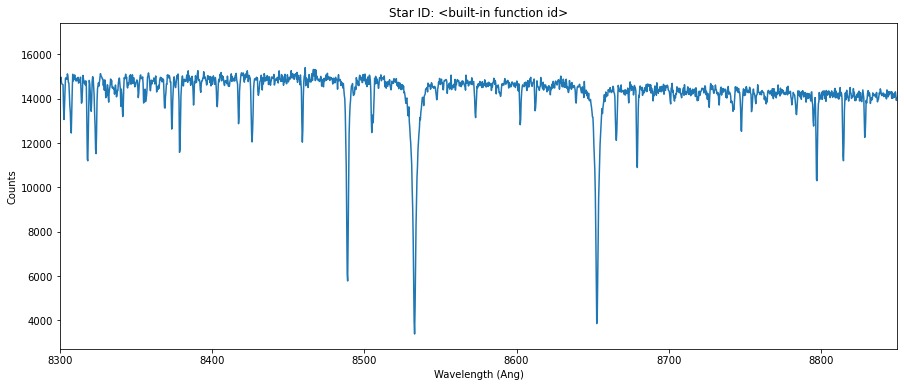

In [395]:
fig,ax = plt.subplots(figsize=(15,6))
data = hdu["SPAT1163-SLIT1162-DET06"].data

plt.plot(data['OPT_WAVE'],data['OPT_COUNTS'])
plt.title('Star ID: {}'.format(id))
plt.xlim(8300,8850)
plt.xlabel('Wavelength (Ang)')
plt.ylabel('Counts')

In [398]:
numpy.log10(data['OPT_WAVE'][1:20]) - numpy.log10(data['OPT_WAVE'][0:19])

array([1.80668166e-05, 1.73462371e-05, 1.80382338e-05, 1.79738969e-05,
       1.80117732e-05, 1.78931430e-05, 1.79395328e-05, 1.79406214e-05,
       1.76918893e-05, 1.78195009e-05, 1.82332728e-05, 1.80286399e-05,
       1.79163661e-05, 1.77985407e-05, 1.80039369e-05, 1.80776364e-05,
       1.79433727e-05, 1.73653636e-05, 1.85214006e-05])

## Reading in a template

In [404]:
template_file = 'lab5_dmost_lte_5000_3.0_-2.0_.fits'

In [428]:
hdu = fits.open(template_file)
print(hdu.info())
print(hdu[1].header)

Filename: lab5_dmost_lte_5000_3.0_-2.0_.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     22   1R x 7C   [210056D, 210056E, D, D, D, 8A, D]   
None
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =              2520712 / length of dimension 1                          NAXIS2  =                    1 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    7 / number of table fields                         TTYPE1  = 'wave    '                                                            TFORM1  = '210056D '       

## The code below is not mine!!!

In [407]:
def read_synthetic_spectrum(pfile):
    '''
    Function to load synthetic template file into python using vacuum wavelengths
    
    Parameters
    ----------
    pfile: str
        path to the synthitic fits file to load. 
        
    Returns
    -------
    pwave: float array
        Wavelengths of synthetic spectrum
    pflux: float array
        Flux of sythetic spectrum
    '''

    with fits.open(pfile) as hdu:
        data     = hdu[1].data
        
    pflux = numpy.array(data['flux']).flatten()
    awave = numpy.exp((data['wave']).flatten())
    

    # CONVERTING AIR WAVELENGTHS TO VACUUM
    s = 10**4 / awave
    n = 1. + 0.00008336624212083 + \
            (0.02408926869968 / (130.1065924522 - s**2)) +\
            (0.0001599740894897 / (38.92568793293 - s**2))

    pwave  = awave*n
    
    return pwave, pflux

Text(0, 0.5, 'Flux')

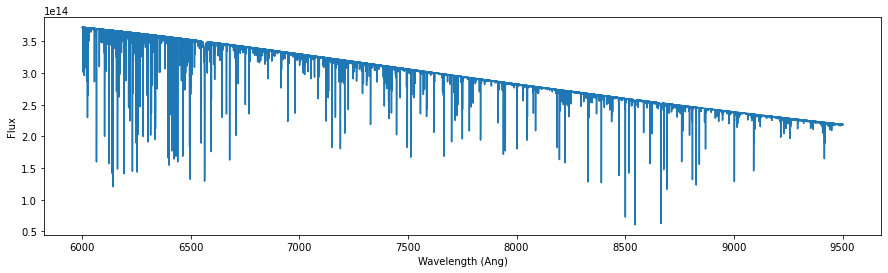

In [408]:
# Read in synthetic spectra and plot wavelegth versus flux
pwave, pflux = read_synthetic_spectrum(template_file)

fig,ax = plt.subplots(figsize=(15,4))
plt.plot(pwave,pflux)
plt.xlabel('Wavelength (Ang)')
plt.ylabel('Flux')

# Exploring the [Catalog of Quasar Properties from Sloan Digital Sky Survey Data Release 16](https://iopscience.iop.org/article/10.3847/1538-4365/ac9ead)

## Reading in the Catalog

In [2]:
test = fits.open("DR16Q_v4.fits")
# test.close()

In [3]:
test.info()

Filename: DR16Q_v4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  CATALOG       1 BinTableHDU    375   750414R x 183C   [18A, D, D, J, J, I, 6A, 6A, I, D, I, D, I, I, I, K, D, I, I, D, I, D, I, D, D, I, D, 12A, D, J, 19A, D, K, D, D, K, D, D, K, D, D, K, D, D, K, D, D, K, D, D, K, D, E, 5D, 5D, 5D, E, D, D, D, D, D, D, D, D, K, K, K, K, K, K, J, J, J, 74J, 74J, 74I, 74I, B, J, 3A, J, J, J, D, D, D, D, 14A, J, D, 5E, 5D, 5E, 5D, 5E, D, D, I, D, D, D, D, I, D, D, D, D, D, D, D, D, E, E, E, E, E, E, E, E, E, I, E, E, E, E, E, E, E, E, E, I, I, D, D, D, D, D, D, J, D, D, D, J, D, D, D, J, D, 21A, D, D, E, E, D, K, D, D, E, E, E, E, E, E, E, D, I, 28A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [258]:
hdu_0 = test[0]
hdu_1 = test[1]

In [259]:
hdu_1.header.keys

<bound method Header.keys of XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2290 / length of dimension 1                          
NAXIS2  =               750414 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  183 / number of table fields                         
TTYPE1  = 'SDSS_NAME'                                                           
TFORM1  = '18A     '                                                            
TTYPE2  = 'RA      '                                                            
TFORM2  = 'D       '                                                            

## Below are three different ways of finding an object in the catalog!

### Using SDSS name

In [257]:
for i in range(len(hdu_1.data)):
    if hdu_1.data[i][0] == "160558.86+474300.1":
        print(i)
        break

604703


### Using PLATE-MJD-FIBER numbers

In [256]:
# 0332-52367-0639
# 6323-56187
for i in range(len(hdu_1.data)):
    if hdu_1.data[i][3] == 6323 and hdu_1.data[i][4] == 56187 and hdu_1.data[i][5] == 638:
        print(i)
        break

### Using SDSS_ID number

In [190]:
for i in range(len(hdu_1.data)):
    if hdu_1.data[i]["OBJID"] == "373974455765985280":
        print(i)
        break

### Coordinate conversion

https://docs.astropy.org/en/stable/coordinates/index.html

In [22]:
SkyCoord('16h05m58.86s', '+47d43m00.22s', frame='icrs')

<SkyCoord (ICRS): (ra, dec) in deg
    (241.49525, 47.71672778)>

In [23]:
object_coor = SkyCoord(ra=184.0307*u.degree, dec=-2.23828*u.degree)
print(object_coor.ra.hms)
print(object_coor.dec.hms)

hms_tuple(h=12.0, m=16.0, s=7.368000000009687)
hms_tuple(h=-0.0, m=-8.0, s=-57.18720000000012)


## Download your object directly from SDSS using RA and DEC!

In [197]:
# JHHMMSS.ss+DDMMSS.s
# et al. 2010 ---> '09h45m33.99s +10d09m50.0s'

# thesis ===> '12h16m07.36s -02d14m17.81s' 

# G. Vietri et al. 2020 ---> 02:04:53.81 −06:04:07.82 

# nikola.. 2009 ---> 130216.13 + 003032.1

# Anna-Christina Eilers et al. 2022 --->  J010013.02+280225.8

# Yipeng Zhou et al. 2022 ---> J160558.86+474300.1

# Most distant quasar observed with JWT (but could not find it) ---> 01h00m13.016s +28d02m25.80s 


pos = coords.SkyCoord('16h05m58.86s +47d43m00.01s', frame='icrs')

xid = SDSS.query_region(pos, spectro=True)
print(xid)

       ra              dec        ...      specobjid       run2d 
---------------- ---------------- ... ------------------- -------
241.495256715896 47.7167040860447 ... 7119240586905755648 v5_10_0
241.495256715896 47.7167040860447 ... 7115732049730707456 v5_10_0


/home/nbal@storm.internal/miniconda3/envs/nozhan_test_env_2/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


In [198]:
hspec = SDSS.get_spectra(matches=xid)

In [254]:
number= 0
hspec[number].info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     121   ()      
  1  COADD         1 BinTableHDU     26   4585R x 8C   ['E', 'E', 'E', 'J', 'J', 'E', 'E', 'E']   
  2  SPALL         1 BinTableHDU    488   1R x 236C   [27A, 14A, 4A, E, E, J, J, E, J, E, E, E, K, K, K, K, K, K, K, K, K, B, B, J, I, 5E, 5E, J, J, J, J, 7A, 7A, 16A, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, 5E, E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 16A, 9A, 12A, E, E, E, E, E, E, E, E, J, E, E, J, J, 6A, 21A, E, 35E, K, 19A, 19A, 19A, B, B, B, I, 3A, B, I, I, I, I, J, E, J, J, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5J, 5J, 5J, 5E, 5J, 75E, 75E, 5E, 5E, 5E, 5J, 5E, D, D, D, D, D, D, D, D, D, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5

In [357]:
hspec[number][1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =                 4585 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    8 / number of table fields                         
TTYPE1  = 'flux    '                                                            
TFORM1  = 'E       '                                                            
TTYPE2  = 'loglam  '                                                            
TFORM2  = 'E       '                                                            
TTYPE3  = 'ivar    '        

In [378]:
h_data   = hspec[number][1].data
h_flux   = h_data["flux"][hspec[number][1].data["and_mask"]==0] * 10**(-17)
h_lambda = 10**h_data["loglam"][hspec[number][1].data["and_mask"]==0]

# sky_flux = hspec[number][1].data["sky"] * 10**(-17)


## Visualising the rest frame spectrum of quasars J160558.86+474300.1 (see figure one in [Yipeng Zhou et al. 2022](https://iopscience.iop.org/article/10.3847/1538-4357/aca085))

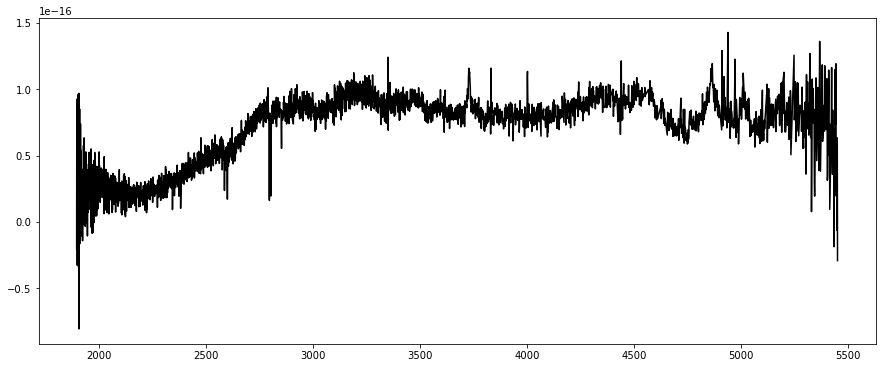

In [379]:
fig, ax = plt.subplots(1, 1, figsize = (15, 6))

plt.plot(h_lambda/1.9, h_flux, "k-")


## Binning the spectrum using astropy (testing different binnings)

In [228]:
from specutils import Spectrum1D
lamb = 10**h_data["loglam"]/5.47 * u.AA 
flux = h_data["flux"] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 
input_spec = Spectrum1D(spectral_axis=lamb, flux=flux) 

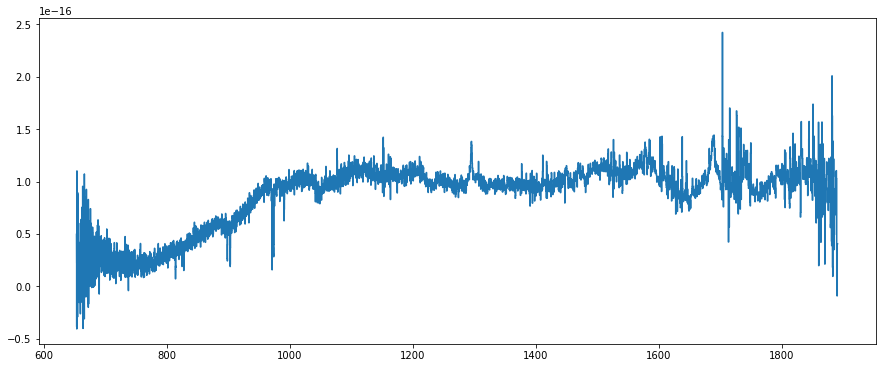

In [229]:
f, ax = plt.subplots(figsize = (15, 6))  
ax.step(input_spec.spectral_axis, input_spec.flux) 

In [155]:
from specutils.manipulation import FluxConservingResampler, LinearInterpolatedResampler, SplineInterpolatedResampler
new_disp_grid = numpy.arange(850, 1650, 0.5) * u.AA

(0.0, 1.087968302834036e-16)

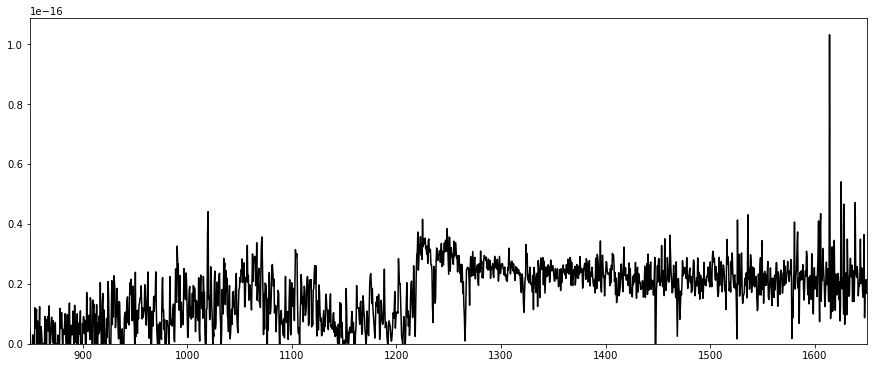

In [160]:
fluxcon = FluxConservingResampler()
new_spec_fluxcon = fluxcon(input_spec, new_disp_grid) 
f, ax = plt.subplots(figsize = (15, 6))  
ax.plot(new_spec_fluxcon.spectral_axis, new_spec_fluxcon.flux, "-k")

ax.set_xlim(850, 1650)
ax.set_ylim(0)

(0.0, 4.792116895099391e-17)

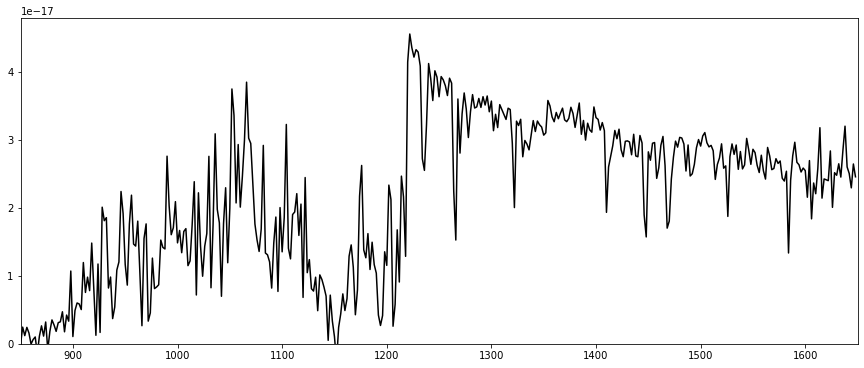

In [127]:
fluxcon = FluxConservingResampler()
new_spec_fluxcon = fluxcon(input_spec, new_disp_grid) 
f, ax = plt.subplots(figsize = (15, 6))  
ax.plot(new_spec_fluxcon.spectral_axis, new_spec_fluxcon.flux, "-k")

ax.set_xlim(850, 1650)
ax.set_ylim(0)

## Trying to fit two gaussians (see eq.2 of [Remington O Sexton et al. 2020](https://academic.oup.com/mnras/article/500/3/2871/5941534)) to two emission lines of a section of a quasar spectrum) 

The model is very simple since neither the continum emission nor the iron temples are included in the model. The goal is to become familiar with the implementation of the EMCEE libraray (that is used below). Also, note that the x axis is subtracted from the mean to test if it makes the convergence of EMCEE sampler easier (faster).

In [203]:
spec_sigma = numpy.array(variance_list)[2830:2900]
spec_x     = h_lambda[2830:2900] - h_lambda[2830:2900].mean()
spec_y     = numpy.array(flux_list)[2830:2900] #- torch.Tensor(flux_list)[2830:2900].mean()
# spec_sigma = 0.05*spec_y.mean()

In [177]:
def spec_model(model_param, predictor = spec_x):
    """This function calculates the Chi-square statistics for a given set of predicted data, 
    their observed counterpart, and their variance."""
    
    output = model_param[0] + model_param[1]*numpy.exp(-0.5 * ((predictor - model_param[5])/model_param[3])**2) + \
            model_param[2]*numpy.exp(-0.5 * ((predictor - model_param[6])/model_param[4])**2)
    
    return output

In [178]:
def spec_lnlike(theta, x, y, yerr):
    
    result = -0.5 * numpy.sum(((y - spec_model(theta, x))/yerr) ** 2)

    return result

In [179]:
def spec_lnprior(theta):
    a0, a1, a2, p1, p2, m1, m2 = theta
    if -100.0 < a0 < 100.0 and -100.0 < a1 < 100.0 and -100.0 < a2 < 100.0 and -2000.0 < p1 < 2000.0 and \
    -200.0 < p2 < 200.0 and -200.0 < m1 < 200.0 and -200.0 < m2 < 200.0:
        return 0.0
    return -numpy.inf

In [180]:
def spec_lnprob(theta, x, y, yerr):
    lp = spec_lnprior(theta)
    if not numpy.isfinite(lp):
        return -numpy.inf
    return lp + spec_lnlike(theta, x, y, yerr)

In [221]:
data     = (spec_x, spec_y, spec_sigma)
nwalkers = 128
niter    = 5000
spec_initial  = numpy.array([45.97635607,   9.12945736,   7.86667475,   6.04200574,   5.73441084,
 -14.16993873,   3.00539373])
ndim     = len(spec_initial)
p0       = [numpy.array(spec_initial) + 1e-7 * numpy.random.randn(ndim) for i in range(nwalkers)]

In [222]:
def spec_main(p0, nwalkers, niter, ndim, lnprob, data):
    sampler  = emcee.EnsembleSampler(nwalkers, ndim, spec_lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [223]:
sampler, pos, prob, state = spec_main(p0,nwalkers,niter,ndim,spec_lnprob,data)


Running burn-in...
Running production...


### Igone the x and y axes labels (old labes from old code)!

In [224]:
plt.rcParams['figure.figsize'] = (20,10)

def plotter(sampler, age=spec_x, T=spec_y):
    plt.ion()
    plt.plot(age,T,label='Change in T')
    samples = sampler.flatchain
    for theta in samples[numpy.random.randint(len(samples), size=100)]:
        plt.plot(age, spec_model(theta, age), color="r", alpha=0.1) # color="C1"
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Years ago')
    plt.ylabel(r'$\Delta$ T (degrees)')
    plt.legend()
    plt.show()

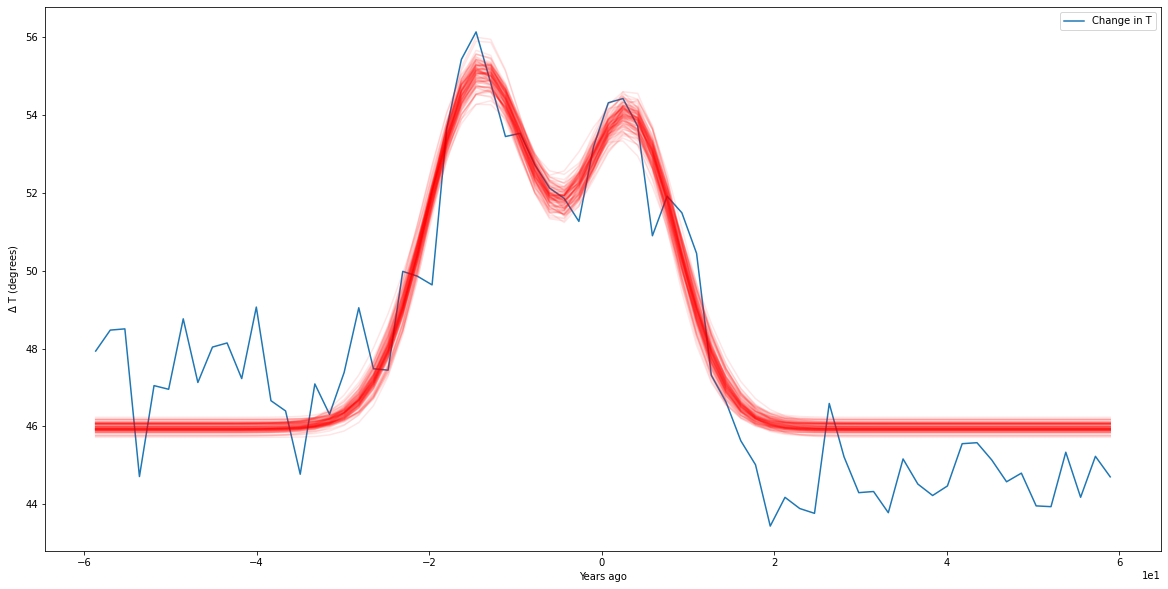

In [225]:
plotter(sampler)
 

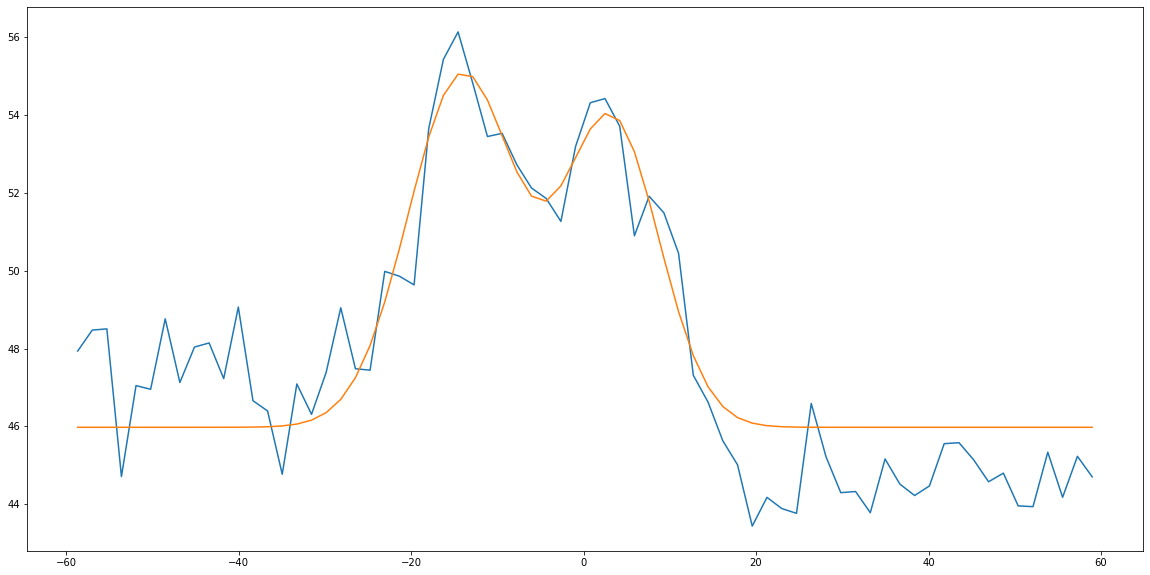

Theta max:  [ 45.9782521    9.05621975   7.8589968    6.265221     5.55624725
 -14.05386143   3.25293933]


In [226]:
samples = sampler.flatchain

theta_max  = samples[numpy.argmax(sampler.flatlnprobability)]
best_fit_model = spec_model(theta_max)
plt.plot(spec_x,spec_y,label='Change in T')
plt.plot(spec_x,best_fit_model,label='Highest Likelihood Model')
plt.show()
print ('Theta max: ',theta_max)

## Breaking the fit into its two gaussian components!

Note that as explained above the goal is not to make an accurate fit (no continuum emission and iron templates have been included)! Just to visualise the output of the EMCEE sampler! Also, note that the x axis is subtracted from the mean to test if it makes the convergence of EMCEE sampler easier (faster).

In [219]:
emission1 = 45.976 + 9.1294 * numpy.exp(-0.5 * ((spec_x + 14.16993) / 6.0420) ** 2)

emission2 = 45.976 + 7.8666 * numpy.exp(-0.5 * ((spec_x - 3.005393) / 5.7344) ** 2)

total_emi = emission1 + emission2 - 45.976

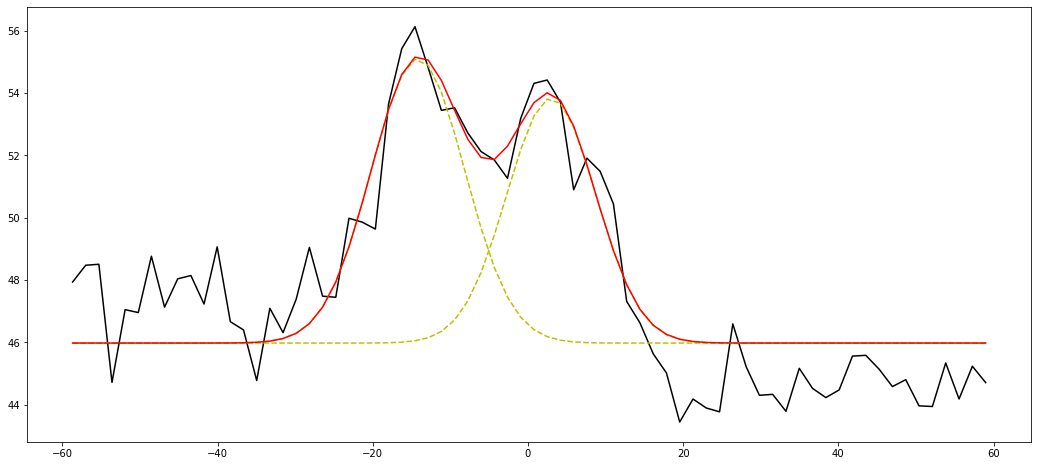

In [228]:
fig, ax = plt.subplots(1, 1, figsize = (18, 8))

ax.plot(spec_x, spec_y, "-k", alpha = 1)

ax.plot(spec_x, emission1, "--y", alpha = 1)

ax.plot(spec_x, emission2, "--y", alpha = 1)

ax.plot(spec_x, total_emi, "-r", alpha = 1)
